![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [5]:
bikes.groupby('season').total.agg(['min', 'max', 'mean', 'median'])

,min,max,mean,median
season,,,,
1,1,801,116.343261,78.0
2,1,873,215.251372,172.0
3,1,977,234.417124,195.0
4,1,948,198.988296,161.0


In [6]:
bikes.groupby('season').total.agg(['quantile', lambda x: x.quantile(0.25), lambda x: x.quantile(0.5), lambda x: x.quantile(0.75)])

,quantile,<lambda_0>,<lambda_1>,<lambda_2>
season,,,,
1,78.0,24.0,78.0,164.0
2,172.0,49.0,172.0,321.0
3,195.0,68.0,195.0,347.0
4,161.0,51.0,161.0,294.0


A partir de las medidas estadísticas para la variable season, se tiene que la estación 1 (invierno) se rentaron en promedio 116 bicicletas, mientras que en primavera (2) 215. Para el verano (3) se presento la cantidad máxima de bicicletas rentadas, 977, y en promedio para esta estación se alquilaron 234 bicicletas, de igual manera el 75% de los datos indica que para el verano se rentaron 347 bicicletas o menos. Finalmente, en otoño (4) en promedio se rentan 199 bicicletas y el 50% de los datos indica que se rentaron 161 bicicletas o menos. De esta manera, la estación de verano es donde más se rentan bicicletas, seguido de la primavera, y en otoño e invierno es donde menos.

In [7]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [8]:
bikes.groupby('hour').total.agg(['min', 'max', 'mean', 'median'])

,min,max,mean,median
hour,,,,
0,2,283,55.138462,41.0
1,1,168,33.859031,19.0
2,1,119,22.899554,11.0
3,1,66,11.757506,6.0
4,1,28,6.407240,6.0
5,1,57,19.767699,19.0
6,1,213,76.259341,75.0
7,1,596,213.116484,208.0
8,8,839,362.769231,392.0


Con respecto a la variable hour, se tiene que las horas en donde más se rentan bicicletas en promedio son 8am, 5 y 6pm; horas que están asociadas a la entrada y salida del trabajo de las personas, por ende muchas personas usan la bicicleta como medio de transporte para llegar a su casa y trabajo. Así mismo, en horas de la madrugada (11pm a 6am) son las horas en que menos se rentan bicicletas en promedio. Al medio día se rentan 257 bicicletas en promedio. La mayor cantidad de bicicletas rentadas son 977, lo cual fue a las 6pm.

La mediana es menor a la media en todas las horas a excepción de las 5pm, esto indica que la distribución de la variable hour es asimétrica. Para las 5pm la mediana indica que se rentaron 481 bicicletas o menos. Mientras que tanto para las 3am como para las 4am se rentaron 6 bicicletas o menos en el 50% de los datos.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

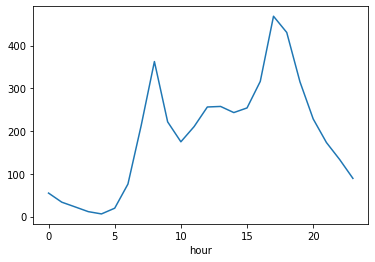

In [9]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

El gráfico muestra que a las 8am, 5pm y 6pm son las horas en que más se rentan bicicletas en promedio, de 12 a 3pm se rentan en promedio alrededor de 200 bicicletas y después de las 7pm la renta de bicicletas disminuye de manera significativa. De igual manera, en las horas de la mañana, 0 a 5am la renta de bicicletas es baja.

<AxesSubplot:xlabel='hour'>

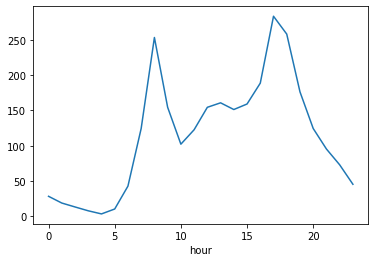

In [10]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes['season'] == 1].groupby('hour')['total'].mean().plot()

Al realizar el análisis por la estación de invierno se tiene el mismo patrón que se evidenciaba en la gráfica general, sin embargo la escala se reduce. Para este caso, las horas en las que más se rentaron bicicletas son las 8am, 5pm y 6pm, con un promedio de aproximadamente 250, 300 y 270 respectivamente. De igual manera, las horas más tempranas de la mañana y las últimas horas de la noche son las que registran menor cantidad de bicicletas alquiladas en promedio.

<AxesSubplot:xlabel='hour'>

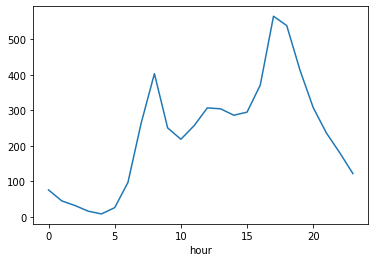

In [11]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes['season'] == 3].groupby('hour')['total'].mean().plot()

Por otro lado, al realizar el análisis por la estación de verano se tiene el mismo patrón que se evidenciaba en la gráfica general, sin embargo la escala se incrementa esto como consecuencia de que en la estación de verano es donde más se alquilan bicicletas. Para este caso, las horas en las que más se rentaron bicicletas son las 8am, 5pm y 6pm, con un promedio de aproximadamente 400, 600 y 550 respectivamente. De igual manera, las horas más tempranas de la mañana y las últimas horas de la noche son las que registran menor cantidad de bicicletas alquiladas en promedio.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [12]:
# Celda 3
#Convertir season a dummys
bikesdm = pd.get_dummies(bikes, columns=['season'], drop_first=True)
bikesdm.head()

,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour,season_2,season_3,season_4
datetime,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,0,1,9.84,14.395,81,0.0,3,13,16,0,False,False,False
2011-01-01 01:00:00,0,0,1,9.02,13.635,80,0.0,8,32,40,1,False,False,False
2011-01-01 02:00:00,0,0,1,9.02,13.635,80,0.0,5,27,32,2,False,False,False
2011-01-01 03:00:00,0,0,1,9.84,14.395,75,0.0,3,10,13,3,False,False,False
2011-01-01 04:00:00,0,0,1,9.84,14.395,75,0.0,0,1,1,4,False,False,False


In [13]:
X = bikesdm[['season_2', 'season_3', 'season_4', 'hour']]  
y = bikesdm['total']

#Modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [14]:
print('Coeficientes:')
for coef, feature in zip(model.coef_, X.columns):
    print(f'{feature}: {coef}')

Coeficientes:
season_2: 100.31723191606106
season_3: 119.46754994593172
season_4: 84.08311787296938
hour: 10.545206094069906


##### Interpretación

* Coeficiente de season_2 (primavera): 100.32. Esto indica que, en comparación con el invierno, el número esperado de bicicletas alquiladas aumenta en 100.32 cuando la temporada es primavera, manteniendo todas las demás variables constantes.
* Coeficiente de season_3 (verano): 119.47. Indica que, en comparación con el invierno, el número esperado de bicicletas alquiladas aumenta en 119.47 cuando la temporada es verano, manteniendo todas las demás variables constantes.
* Coeficiente de season_4 (otoño): 84.08. Indica que, en comparación con el invierno, el número esperado de bicicletas rentadas aumenta en 84.08 cuando la temporada es otoño, manteniendo todas las demás variables constantes.
* Coeficiente de hour (hora): 10.55. Manteniendo todas las demás variables constantes, por cada hora adicional en el día, se espera un aumento de 10.55 en el número total de bicicletas alquiladas.

¿Cuáles son las limitaciones de la regresión lineal en este caso? Las limitaciones son que la regresión lineal puede tener dificultades para predecir valores extremos o fuera del rango de los datos observados, también que es sensible a datos atipicos. Adicionalmente se ven limitados en los supuestos que se deben cumplir para la regresión lineal.  

In [15]:
###Rendimiento del modelo
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print("Coeficiente de determinación (R2):", r2)

Coeficiente de determinación (R2): 0.22339339904452493


El coeficiente de determinación indica que el modelo de regresión lineal explica aproximadamente el 22.34% de la variabilidad del número total de bicicletas alquiladas. Por lo tanto, el modelo de regresión lineal no es muy efectivo para predecir el número total de bicicletas alquiladas basado únicamente en las variables predictoras seleccionadas: las estaciones y la hora. 

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [16]:
# Celda 4

def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [17]:
X = bikes[['season', 'hour']]  
y = bikes['total']
tree_grow(X, y, level=0, min_gain=0.001, max_depth=6, num_pct=10)

{'y_pred': 1,
 'y_prob': 191.53903379867745,
 'level': 0,
 'split': [1, 8.0],
 'n_samples': 10886,
 'gain': 18268.811823533004,
 'sl': {'y_pred': 1,
  'y_prob': 55.40711902113459,
  'level': 1,
  'split': [1, 7.0],
  'n_samples': 3594,
  'gain': 7207.700659959655,
  'sl': {'y_pred': 1,
   'y_prob': 32.561604584527224,
   'level': 2,
   'split': [1, 6.0],
   'n_samples': 3139,
   'gain': 646.8008927589567,
   'sl': {'y_pred': 1,
    'y_prob': 25.15934475055845,
    'level': 3,
    'split': [1, 2.0],
    'n_samples': 2684,
    'gain': 382.8088308604629,
    'sl': {'y_pred': 1,
     'y_prob': 44.41383095499451,
     'level': 4,
     'split': [0, 2.0],
     'n_samples': 909,
     'gain': 291.4004681825131,
     'sl': {'y_pred': 1,
      'y_prob': 23.32456140350877,
      'level': 5,
      'split': [1, 1.0],
      'n_samples': 226,
      'gain': 45.41972746495435,
      'sl': {'y_pred': 1,
       'y_prob': 27.808695652173913,
       'level': 6,
       'split': -1,
       'n_samples': 113,
 

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

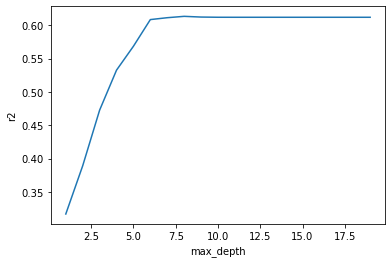

In [18]:
# Celda 5
max_depth_range = range(1,20)
r2_scores=[]

X = bikes[['season', 'hour']]  
y = bikes['total']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

for depth in max_depth_range:
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    r2_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='r2').mean())

import matplotlib.pyplot as plt
plt.plot(max_depth_range, r2_scores)
plt.xlabel('max_depth')
plt.ylabel('r2')
plt.show()

In [19]:
sorted(zip(r2_scores, max_depth_range))[::-1][0]

(0.6134052369062071, 8)

In [20]:
###Arbol final
clf = DecisionTreeRegressor(max_depth=8, random_state=1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
r2_arbol = r2_score(y_test, y_pred)
print("Coeficiente de determinacion (R2) árbol de regresión:", r2_arbol)

print("Coeficiente de determinacion (R2) regresión lineal:", r2)

Coeficiente de determinacion (R2) árbol de regresión: 0.5780261588685437
Coeficiente de determinacion (R2) regresión lineal: 0.22339339904452493


Comparando los dos coeficientes de determinación, se tiene que el árbol de decisión presentan un $R^2$ de 0.578 el cual es superior al que se obtuvo en el modelo de regresión lineal. Un coeficiente de determinación  de aproximadamente 0.578 en un árbol de regresión indica que este modelo es capaz de explicar alrededor del 57.80% de la variabilidad del número total de bicicletas alquiladas.

Comparado con el modelo de regresión lineal que presenta un un $R^2$ de 0.22 , el árbol de regresión parece ser más efectivo para capturar la variabilidad en los datos y predecir el número total de bicicletas rentadas. Sin embargo, aún queda una parte considerable de la variabilidad que no se explica por el modelo.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [21]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [22]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [23]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [24]:
max_depth_range = range(1,10)
accuracy_scores=[]

for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

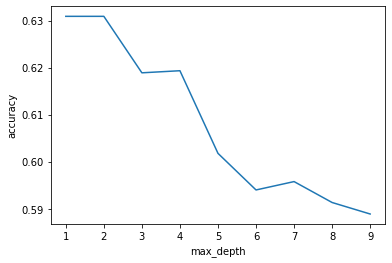

(0.6308888888888888, 2)

In [25]:
import matplotlib.pyplot as plt    
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

In [26]:
# Celda 6

###Arbol de decisión
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)  # Se calibra el parámetro max_depth
tree_clf.fit(X_train, y_train)

#Evaluación del árbol
y_pred_tree = tree_clf.predict(X_test)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
f1_score_tree = f1_score(y_test, y_pred_tree)

print("Desempeño del árbol de decisión:")
print("Accuracy:", accuracy_tree)
print("F1-Score:", f1_score_tree)

Desempeño del árbol de decisión:
Accuracy: 0.6453333333333333
F1-Score: 0.6448598130841121


* Accuracy: Esto significa que el 64.53% de las predicciones realizadas sobre la popularidad de un articulo por el modelo son correctas.
* F1-Score: Un F1-Score del 64.49% es bastante razonable y sugiere que el modelo está logrando un buen equilibrio entre la precisión y el recall.

In [27]:
### Regresión logística
logistica = LogisticRegression(max_iter=1000, random_state=42)  
logistica.fit(X_train, y_train)

#Evaluación del modelo
y_pred_logistica = logistica.predict(X_test)
accuracy_logistica= accuracy_score(y_test, y_pred_logistica)
f1_score_logistica = f1_score(y_test, y_pred_logistica)

print("\nDesempeño de la regresión logística:")
print("Accuracy:", accuracy_logistica)
print("F1-Score:", f1_score_logistica)


Desempeño de la regresión logística:
Accuracy: 0.616
F1-Score: 0.6043956043956044


* Accuracy: Esto significa que el 61.6% de las predicciones realizadas sobre la popularidad de un articulo por el modelo son correctas.
* F1-Score: Un F1-Score del 60.44% es bastante razonable y sugiere que el modelo está logrando un buen equilibrio entre la precisión y el recall.

En comparación con el árbol de decisión, la regresión logística tiene un desempeño inferior para predecir si la noticia es popular o no.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [28]:
# Celda 7

# Creación de 300 muestras de bootstrap
n_estimators = 300
np.random.seed(123)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

# Entrenamiento de 300 modelos con las 300 muestras boostrap
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

models = []

for i in range(n_estimators):
    if i < 100: # Primeras 100 muestras son árboles de decisión con max_depth
        model = DecisionTreeClassifier(max_depth=5, random_state=seeds[i])
    elif i < 200: # Siguientes 100 muestras son árboles de decisión con min_samples_leaf
        model = DecisionTreeClassifier(min_samples_leaf=10, random_state=seeds[i])
    else: # Últimas 100 muestras son regresiones logísticas
        model = LogisticRegression()
    model.fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    models.append(model) 
    
# Evaluar modelos por separado
metrics_scores = {}

for i, model in enumerate(models):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    metrics_scores[f'Model_{i+1}'] = {'Accuracy': accuracy, 'F1-Score': f1}

# Resultados de accuracy y F1-Score para cada modelo
for model, scores in metrics_scores.items():
    print(f'{model}: Accuracy = {scores["Accuracy"]:.4f}, F1-Score = {scores["F1-Score"]:.4f}')

Model_1: Accuracy = 0.6367, F1-Score = 0.6422
Model_2: Accuracy = 0.6280, F1-Score = 0.6405
Model_3: Accuracy = 0.6140, F1-Score = 0.6075
Model_4: Accuracy = 0.6227, F1-Score = 0.6590
Model_5: Accuracy = 0.6380, F1-Score = 0.6378
Model_6: Accuracy = 0.6187, F1-Score = 0.6171
Model_7: Accuracy = 0.6100, F1-Score = 0.6045
Model_8: Accuracy = 0.6287, F1-Score = 0.6486
Model_9: Accuracy = 0.6353, F1-Score = 0.6404
Model_10: Accuracy = 0.6140, F1-Score = 0.6143
Model_11: Accuracy = 0.6260, F1-Score = 0.6336
Model_12: Accuracy = 0.6293, F1-Score = 0.6472
Model_13: Accuracy = 0.6260, F1-Score = 0.6258
Model_14: Accuracy = 0.6167, F1-Score = 0.6368
Model_15: Accuracy = 0.6207, F1-Score = 0.6229
Model_16: Accuracy = 0.5973, F1-Score = 0.5728
Model_17: Accuracy = 0.6313, F1-Score = 0.6184
Model_18: Accuracy = 0.6107, F1-Score = 0.5858
Model_19: Accuracy = 0.5980, F1-Score = 0.5595
Model_20: Accuracy = 0.6327, F1-Score = 0.6304
Model_21: Accuracy = 0.6353, F1-Score = 0.6505
Model_22: Accuracy = 0

In [29]:
# Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = models[i].predict(X_test)
y_pred_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
1483,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2185,1,1,0,1,1,1,1,1,1,0,...,0,1,1,0,1,1,0,0,0,0
2520,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3721,1,1,1,0,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3727,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3077,1,1,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
5166,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2227,1,1,1,1,0,1,1,1,1,1,...,0,1,1,0,1,0,1,1,1,0
5684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# Votación mayoritaria
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
f1_voting=f1_score(y_pred, y_test)
accuracy_voting =accuracy_score(y_pred, y_test)

print("Desempeño del ensamble con Votación Mayoritaria:")
print("Accuracy:", accuracy_voting)
print("F1-Score:", f1_voting)

Desempeño del ensamble con Votación Mayoritaria:
Accuracy: 0.6286666666666667
F1-Score: 0.6239027683997299


* Accuracy: En este caso, el ensamble con votación mayoritaria tiene un accuracy de aproximadamente 0.6287, lo que significa que alrededor del 62.87% de las predicciones realizadas por el ensamble son correctas.
* F1-Score: Un F1-Score de aproximadamente 0.6239 indica que el ensamble tiene un buen equilibrio entre precisión y recall en sus predicciones.

En resumen, estos resultados indican que el ensamble con votación mayoritaria es capaz de hacer predicciones con un nivel razonable de precisión. 

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [32]:
# Celda 8
from sklearn import metrics
samples_oob = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))
    
errors = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_ = models[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)
    
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
alpha = (1 - errors) / (1 - errors).sum()
alpha

array([0.00352778, 0.00351128, 0.00344145, 0.00336159, 0.00343863,
       0.00346891, 0.00335148, 0.00333339, 0.00348271, 0.0033873 ,
       0.00338032, 0.00336898, 0.00341407, 0.0034316 , 0.0034145 ,
       0.00351601, 0.00345738, 0.00341583, 0.00336968, 0.00347453,
       0.00348844, 0.00349555, 0.00342207, 0.00346369, 0.00342172,
       0.00344685, 0.00334307, 0.00345649, 0.00334603, 0.00343187,
       0.00334134, 0.00347101, 0.00344016, 0.00334461, 0.00328471,
       0.00336847, 0.00328577, 0.0034277 , 0.00328993, 0.00337109,
       0.00342863, 0.00334966, 0.00343201, 0.00335271, 0.00328993,
       0.00346766, 0.00338618, 0.00333831, 0.00334025, 0.00347858,
       0.00339703, 0.00340933, 0.0033495 , 0.00350309, 0.00354899,
       0.00351555, 0.00338786, 0.00335207, 0.00333072, 0.00329583,
       0.00336839, 0.00337513, 0.00344612, 0.00347167, 0.00315781,
       0.00335889, 0.00335471, 0.00339994, 0.00336568, 0.00352455,
       0.00346749, 0.0034117 , 0.0034354 , 0.00336982, 0.00333

In [33]:
# Ponderación de las predicciones con los pesos alpha
weighted_sum_1 = ((y_pred_df) * alpha).sum(axis=1)
weighted_sum_1.head(10)

1483    0.917156
2185    0.670817
2520    0.818911
3721    0.868185
3727    0.081025
4524    0.749906
234     0.061199
4735    0.187869
5839    0.470752
2939    0.679164
dtype: object

In [34]:
y_pred = (weighted_sum_1 >= 0.5).astype(np.int)

f1_voting_wh=f1_score(y_pred, y_test)
accuracy_voting_wh =accuracy_score(y_pred, y_test)

print("Desempeño del ensamble con Votación ponderada:")
print("Accuracy:", accuracy_voting_wh)
print("F1-Score:", f1_voting_wh)

Desempeño del ensamble con Votación ponderada:
Accuracy: 0.6253333333333333
F1-Score: 0.6202702702702702


* Accuracy: En este caso, el ensamble con votación ponderada tiene un accuracy de aproximadamente 0.6253, lo que significa que alrededor del 62.53% de las predicciones realizadas por el ensamble son correctas en indicar si una noticia es popular o no.
* F1-Score: Un F1-Score de aproximadamente 0.62 indica que el ensamble tiene un buen equilibrio entre precisión y recall en sus predicciones.


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

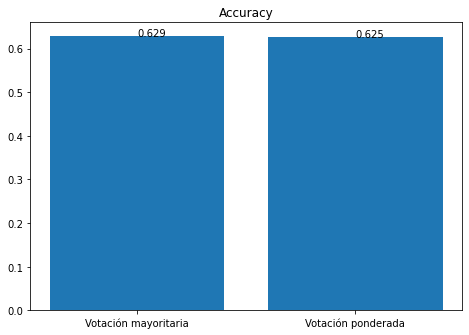

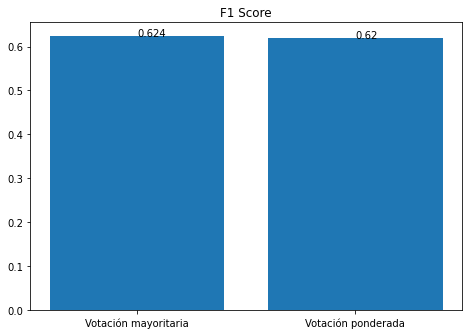

In [35]:
# Celda 9

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Accuracy")
ejeX = ['Votación mayoritaria', 'Votación ponderada']
ejeY = [accuracy_voting,accuracy_voting_wh]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],round(y[i],3))
addlabels(ejeX,ejeY,plt)
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("F1 Score")
ejeX = ['Votación mayoritaria', 'Votación ponderada']
ejeY = [f1_voting,f1_voting_wh]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],round(y[i],3))
addlabels(ejeX,ejeY,plt)
plt.show()

Teniendo en cuenta las medidas de Accuracy y F1 score, se tiene que el modelo con votación mayoritaria tiene un mejor desempeño en comparación con el modelo con votación ponderada. Ambos ensambles muestran resultados bastante similares en términos de accuracy y F1-Score. 

* Accuracy: En este caso, el ensamble con votación mayoritaria tiene un accuracy de aproximadamente 0.6287, lo que significa que alrededor del 62.87% de las predicciones para determinar si una noticia es popular o no son correctas.
* F1-Score: Un F1-Score de aproximadamente 0.6239 indica que el ensamble tiene un buen equilibrio entre precisión y recall en sus predicciones.

La votación mayoritaria es más simple pero puede no tener en cuenta la confianza de los modelos, es decir que todos los votos tienen el mismo peso, lo que significa que los modelos menos confiables tienen el mismo impacto en la predicción final. Mientras que la votación ponderada puede considerar la confianza pero es más compleja y depende de la selección adecuada de pesos. 